<h2>Linear Regression - Ridge regression using only numpy and math libraries</h2>

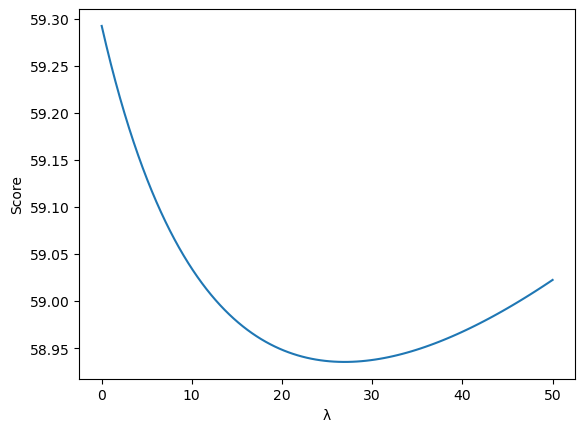

Lambda opt: 26.77232323232323
RMSE (Root Mean Square Error): 50.932138340778366


In [1]:
# Load data, delete output column, make feature matrix with one extra column of ones
import matplotlib.pyplot as plt
import numpy as np
from math import *
import pickle

data = np.loadtxt('data.csv', delimiter = ',')

pred_sa1 = np.insert(data, 0, 1, axis = 1) # insert column of ones in front of first column
pred_ = np.delete(pred_sa1, 6, axis = 1) # delete last column

pred_novi = np.insert(pred_, 6, [[0]] * 15, axis = 1) # insert 15 columns of all zeros

for i in range(0, len(pred_novi)): # fill the feature matrix with linear combination of features instead of zeros
    kk = 0
    q = 0
    for j in range(6, 21):
        pred_novi[i][j] = pred_novi[i][kk + 1] * pred_novi[i][q + 1]
        q = q + 1
        if q == 5:
            kk = kk + 1
            q = kk
            
# output vector
izlazi = np.loadtxt('data.csv', delimiter = ',')
izlazi = np.delete(izlazi, [0, 1, 2, 3, 4], axis = 1) # delete columns except the last one

# standardization
sr_vr = [] # vector of mean values for all features
for j in range(1, 21):
    suma = 0
    std_clan = 0
    std2 = 0
    for i in range(0, len(pred_novi)):
        suma += pred_novi[i][j]
    sr_vr.append(suma / len(pred_novi)) # calculate the mean values
    
    for k in range(0, len(pred_novi)):
        std_clan += (pred_novi[k][j] - sr_vr[j - 1]) ** 2 # calculate the sum for std dev
    std2 = 1 / len(pred_novi) * std_clan # std_dev ^ 2
    
    for q in range(0, len(pred_novi)):
        pred_novi[q][j] = (pred_novi[q][j] - sr_vr[j - 1]) / sqrt(std2)
        
# delete the first column of ones because of Ridge
pred_novi = np.delete(pred_novi, 0, axis = 1)

test_data = np.delete(pred_novi, np.s_[0:300], 0) # delete all input examples except the last 42 which represents test data
test_Y = np.delete(izlazi, np.s_[0:300], 0) # delete all output examples except the last 42 which represents test data

tete = [] # theta parameter
lamb = np.linspace(0.01, 50, 100) # len(lamb) = 100

fold = []
fold_Y = []
K = 5 # number of folds

for i in range(0, K): # every out of 5 folds has 60 examples of data
    fold.append(pred_novi[0 + i * 60:60 + i * 60][:])
    fold_Y.append(izlazi[0 + i * 60:60 + i * 60])

br = 0
metrika = []

for j in range(0, len(lamb)):
    sr_kvad_gr = []
    for i in range(0, K):
        br = br + 1
        trening_skup = np.concatenate((fold[i], fold[(i + 1) % 5], fold[(i + 2) % 5], fold[(i + 3) % 5]), axis = 0)
        y_skup = np.concatenate((fold_Y[i], fold_Y[(i + 1) % 5], fold_Y[(i + 2) % 5], fold_Y[(i + 3) % 5]), axis = 0)
        validacioni_skup = fold[(i + 4) % 5]
        validaciono_y = fold_Y[(i + 4) % 5]

        # determine Ridge parameters - centering of inputs and outputs

        # mean value of training data
        sr_vr_trening = []
        for l in range(0, 20):
            suma_trening = 0
            for k in range(0, len(trening_skup)):
                suma_trening += trening_skup[k][l]
            sr_vr_trening.append(suma_trening / len(trening_skup))

        # centering training data
        for m in range(0, 20):
            for n in range(0, len(trening_skup)):
                trening_skup[n][m] = trening_skup[n][m] - sr_vr_trening[m]

        # mean value of output data
        sr_vr_izlaz = 0
        suma_izlaz = 0
        for k in range(0, len(y_skup)):
            suma_izlaz += y_skup[k][0]
        sr_vr_izlaz = suma_izlaz / len(y_skup)

        # centering output data
        for k in range(0, len(y_skup)):
            y_skup[k][0] = y_skup[k][0] - sr_vr_izlaz
            
        # determine theta and theta_zero parameters
        tete.append(np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(trening_skup), trening_skup) + lamb[j] * np.identity(20)), np.transpose(trening_skup)), y_skup))
        teta_nula = sr_vr_izlaz

        y_tilda = np.dot(validacioni_skup, tete[br - 1]) + teta_nula

        suma_kvadrata_gresaka = 0
        for k in range(0, len(y_tilda)):
            suma_kvadrata_gresaka += (validaciono_y[k][0] - y_tilda[k][0]) ** 2
        sr_kvad_gr.append(suma_kvadrata_gresaka / len(y_tilda))
        
    suma_gr = 0
    for q in range(0, len(sr_kvad_gr)):
        suma_gr += sr_kvad_gr[q]
    metrika.append(sqrt(suma_gr / len(sr_kvad_gr)))

# determine Ridge parameters - centering of inputs and outputs for whole training dataset
trening_skup_ceo = np.concatenate((fold[0], fold[1], fold[2], fold[3], fold[4]), axis = 0)
y_skup_ceo = np.concatenate((fold_Y[0], fold_Y[1], fold_Y[2], fold_Y[3], fold_Y[4]), axis = 0)

# mean value of all the features
sr_vr_pred = []
for l in range(0, 20):
    suma_prediktora = 0
    for k in range(0, len(trening_skup_ceo)):
        suma_prediktora += trening_skup_ceo[k][l]
    sr_vr_pred.append(suma_prediktora / len(trening_skup_ceo))

# centering of the features
for m in range(0, 20):
    for n in range(0, len(trening_skup_ceo)):
        trening_skup_ceo[n][m] = trening_skup_ceo[n][m] - sr_vr_pred[m]

# mean value of output data
sr_vr_izlaz_test = 0
suma_izlaz_test = 0
for k in range(0, len(y_skup_ceo)):
    suma_izlaz_test += y_skup_ceo[k][0]
sr_vr_izlaz_test = suma_izlaz_test / len(y_skup_ceo)

# centering output data
for k in range(0, len(y_skup_ceo)):
    y_skup_ceo[k][0] = y_skup_ceo[k][0] - sr_vr_izlaz_test

# lambda opt
optimalno_lamb = lamb[metrika.index(min(metrika))] # = 26.77232323232323
    
# determine theta parameters
tete_optimalno = []
tete_optimalno.append(np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(trening_skup_ceo), trening_skup_ceo) + optimalno_lamb * np.identity(20)), np.transpose(trening_skup_ceo)), y_skup_ceo))
teta_optimalno_nula = sr_vr_izlaz_test

y_tilda_optimalno = np.dot(test_data, tete_optimalno[0]) + teta_optimalno_nula

sr_kvad_gr_modela = 0
suma_kvadrata_gresaka_test = 0
for k in range(0, len(test_Y)):
    suma_kvadrata_gresaka_test += (test_Y[k][0] - y_tilda_optimalno[k][0]) ** 2
sr_kvad_gr_modela = suma_kvadrata_gresaka_test / len(test_Y)

# array of theta opt
naucene_tete = []
naucene_tete.append(teta_optimalno_nula)
for i in range(0, len(tete_optimalno[0])):
    naucene_tete.append(tete_optimalno[0][i][0]) # teta0, teta1, ... ,teta20

# write theta opt into tete.csv file
with open('tete.csv', 'wb') as f:
    pickle.dump(naucene_tete, f)

# write vector of mean values into sr_vr.csv file
with open('sr_vr.csv', 'wb') as g:
    pickle.dump(sr_vr, g)
    
def model(X):
    # load tete.csv file into a variable
    with open('tete.csv', 'rb') as f:
        loaded = pickle.load(f)
    # load sr_vr.csv file into a variable
    with open('sr_vr.csv', 'rb') as g:
        sr_vr_loaded = pickle.load(g)

    # linear combinations
    X_sa1 = np.insert(X, 0, 1, axis = 1) # insert column of ones in front of first column
    X_novo = np.insert(X_sa1, 6, [[0]] * 15, axis = 1) # insert 15 columns of all zeros

    # fill the feature matrix with linear combination of features instead of zeros
    for i in range(0, len(X_novo)):
        kk = 0
        q = 0
        for j in range(6, 21):
            X_novo[i][j] = X_novo[i][kk + 1] * X_novo[i][q + 1]
            q = q + 1
            if q == 5:
                kk = kk + 1
                q = kk
    
    # standardization
    for j in range(1, 21):
        std_clan_model = 0
        std2_model = 0
        for k in range(0, len(X_novo)):
            std_clan_model += (X_novo[k][j] - sr_vr_loaded[j - 1]) ** 2 # calculate sum for std dev
        std2_model = 1 / len(X_novo) * std_clan_model # std_dev ^ 2

        for q in range(0, len(X_novo)):
            X_novo[q][j] = (X_novo[q][j] - sr_vr_loaded[j - 1]) / sqrt(std2_model)
    return np.dot(X_novo, loaded)

plt.plot(lamb, metrika)
plt.xlabel('\u03BB')
plt.ylabel('Score')
plt.show()

print("Lambda opt:", optimalno_lamb) # = 26.77232323232323

print("RMSE (Root Mean Square Error):", sqrt(sr_kvad_gr_modela)) # = 50.932138340778366